Copyright (c) 2017,2018, Johannes Schöneberg. All rights reserved.
The default copyright laws apply.

In [2]:
import csv


#http://soft-matter.github.io/trackpy/v0.3.2/tutorial/walkthrough.html


from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
#mpl.rc('figure',  figsize=(10, 6))
#mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims

import scipy


import math



import scipy.ndimage

#own modules / functions
import sys
pythonPackagePath = "/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis/"
sys.path.append(pythonPackagePath+"/modules")
import InputProcessing as inproc
import ForceFileProcessing as ffp
import TubeProcessing as tubeProc


#### plot definitions
#https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
#c_ch1 = 'aqua'
#c_ch1 = 'deepskyblue'
#c_ch1 = 'cyan'

#c_ch2 = 'springgreen'
#c_ch2 = 'lime'
#c_ch3 = 'red'
#lwidth = 3

#xlimit = (-150,300)

In [47]:
# read input parameters:
path = '/Users/johannesschoeneberg/Dropbox/ESCRT_data_sharing/m2_2018-06-05_v10/'

inputParameters = pd.read_csv(path+'_info.csv',names=['key','value'])
inputParameters

,key,value
0,key,value
1,description,nice vesicle; nice tube; junction spot; punct...
2,input_data_folder,
3,output_data_folder,
4,vesicleID_of_that_day,TBD
5,forceFile_raw_originalFilename,measurement__152.lvm
6,forceFile_raw_dataShareFilename,forceFile_raw.lvm
7,forceFile,forceFile.csv
8,forceFile_plot,forceFile.png
9,forceFile_alpha_y,-1519


In [4]:
# read the tube vector from a previous step

inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")
tubeVectorFileName = inproc.getInputParameter(inputParameters,"tubeVector_file")

#path = '/Volumes/Samsung_T3b/science/confleezers/2018-06-05/v10all/'

df_tubeVector = pd.read_csv(path+inputDataFolder+'/'+tubeVectorFileName)
df_tubeVector.columns=['frame','tubeLenght',"vesicle_attachment_x",'vesicle_attachment_y','bead_attachment_x','bead_attachment_y']
df_tubeVector[0:5]


,frame,tubeLenght,vesicle_attachment_x,vesicle_attachment_y,bead_attachment_x,bead_attachment_y
0,0,37.013511,172.0,115.0,135.0,114.0
1,1,37.013511,172.0,115.0,135.0,114.0
2,2,37.054015,172.0,116.0,135.0,114.0
3,3,37.054015,172.0,116.0,135.0,114.0
4,4,37.054015,172.0,116.0,135.0,114.0


# calculate tube intensity for channel 0

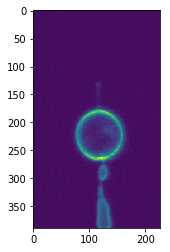

In [5]:
inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")
movie_zoomVesicle_ch0 = "movie_ch0_avg20_bleachCorrected.tif"

frames_ch0 = pims.TiffStack_pil(path+inputDataFolder+'/'+movie_zoomVesicle_ch0) 
plt.imshow(frames_ch0[0])

[ 149.  117.]


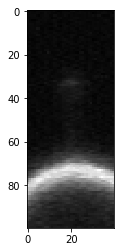

In [6]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch0

frameId = 500
image = frames[frameId]
marginx = 50
marginy = 20
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)
midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()

# fit tube to a gaussian for on frame in the movie

[ 149.  117.]
32.0156211872
12 12


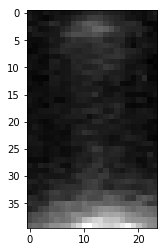

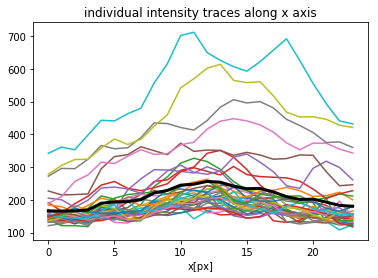

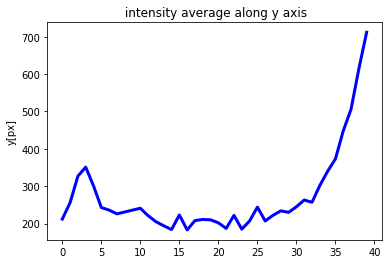

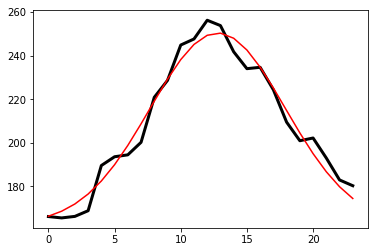

mean: 12.7948499342 stdev: 5.11035992336 max: 250.403532759 FWHM: 12.0348976195 offset: 162.473489366 maxx: 250.403532759
fit parameters: mean: 12.794849934232602 variance: -5.110359923360999 amplitude: -1126.3638673842343 yshift: 162.47348936563037


In [7]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points



frames = frames_ch0

frameId = 500
image = frames[frameId]
marginx = 20
marginy = -1 # will be calculated from tube length

#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)

tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
print(tubeLength)
marginy = int(0.8*tubeLength/2)
print(marginy,marginy)

midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()


#----------------
# look at the individual lines

for line in image_centeredOnVesicleAttachmentVector:
    plt.plot(line)

plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
plt.title('individual intensity traces along x axis')
plt.xlabel('x[px]')
plt.show()

maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
plt.plot(maximaForEveryLine,color='b',lw=3)
plt.title(' intensity average along y axis')
plt.ylabel('y[px]')
plt.show()


#----------------
# average the individual lines

averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
# guess that the center sits on the max                               
guess_mean = np.argmax(averagedIntensity)
# guess that the variance is where the halfmax is
halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
# get the indexes of the elements to the right of the maximum that are larger than the halfmax
indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
# the length of that list is our sigma guess
guess_sigma = len(indexes)

# our guess for the y-shift is the minimum of the averaged traces
guess_yShift = np.min(averagedIntensity)

# out guess for the amplitude is the difference between min and max of the trace
guess_amplitude = halfmax*2


                               
                               
                               
#----------------  
# do the fit:
                               
p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
#print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=True);


amplitude = fit[5] #maxx-offset




# fit tube to a gaussian for all frames in the movie

In [48]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch0

outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")

verbose = False
fits = []

counter = 0
#for frameId in range(0,10):
for frameId in range(0,len(frames)):
    
    if(counter%10==0):
        print(counter)
    try:
        image = frames[frameId]
        marginx = 20
        marginy = -1 # will be calculated from tube length
        
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                          df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
        beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                          df_tubeVector['bead_attachment_y'].iloc[frameId]]
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
        #print(tubeMidpoint)
        
        tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
        #print(tubeLength)
        marginy = int(0.8*tubeLength/2)
        #print(marginy,marginy)
        
        midx = int(tubeMidpoint[0])
        midy = int(tubeMidpoint[1])
        image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]
    
        if(verbose):
            plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')
            plt.show()
            
            
        try:    
            maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
            filename_maxEveryLine = path+outputDataFolder+movie_zoomVesicle_ch0+'__flIntMaxAlongTube_'+str(counter)+'.csv'
            df = pd.DataFrame(maximaForEveryLine)
            df.to_csv(filename_maxEveryLine, header=['fluorescenceMaximaForEveryLineAlongTubeVector'])
        except ValueError:
            print('something went wrong. skip')
            
        if(verbose):
            plt.plot(maximaForEveryLine,color='b',lw=3)    
            plt.show()
        
        
        if(verbose):
            for line in image_centeredOnVesicleAttachmentVector:
                plt.plot(line)
            plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
            plt.show()
        
        averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
        # guess that the center sits on the max                               
        guess_mean = np.argmax(averagedIntensity)
        # guess that the variance is where the halfmax is
        halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
        # get the indexes of the elements to the right of the maximum that are larger than the halfmax
        indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
        # the length of that list is our sigma guess
        guess_sigma = len(indexes)
        
        # our guess for the y-shift is the minimum of the averaged traces
        guess_yShift = np.min(averagedIntensity)
        
        # out guess for the amplitude is the difference between min and max of the trace
        guess_amplitude = halfmax*2
        
        
                                       
                                       
                                       
                
        
                                       
        p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
        if(False):
            print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
       
        fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=False);
    except (TypeError, ZeroDivisionError,IndexError) as e:
        fit = np.array([])
    fits.append(fit)
    counter = counter +1
    
    

fits = np.array(fits)

fits = np.array(fits)
filenamePath_gaussFit_ch0 = path+outputDataFolder+movie_zoomVesicle_ch0+'__gaussFitAlongTube.csv'
df = pd.DataFrame(fits.tolist())
df.to_csv(filenamePath_gaussFit_ch0,header=['mean','stdev','fit[0][2]','offset','maxx','maxx-offset','FWHM','fitconvergence','background_median','maxx-background_median'])

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420


/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in multiply
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2))

1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


1800
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1810
1820
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1830
something went wrong. skip
something went wrong. skip


In [17]:
time = deltaT + np.arange(0,1723)*frameRate
time2 = deltaT + 100+np.arange(1724,len(frames))*frameRate
print(time)
print(time2)
time = np.concatenate([time,time2])
print(time)

[ -70.     -69.667  -69.334 ...,  502.76   503.093  503.426]
[ 604.092  604.425  604.758  605.091  605.424  605.757  606.09   606.423
  606.756  607.089  607.422  607.755  608.088  608.421  608.754  609.087
  609.42   609.753  610.086  610.419  610.752  611.085  611.418  611.751
  612.084  612.417  612.75   613.083  613.416  613.749  614.082  614.415
  614.748  615.081  615.414  615.747  616.08   616.413  616.746  617.079
  617.412  617.745  618.078  618.411  618.744  619.077  619.41   619.743
  620.076  620.409  620.742  621.075  621.408  621.741  622.074  622.407
  622.74   623.073  623.406  623.739  624.072  624.405  624.738  625.071
  625.404  625.737  626.07   626.403  626.736  627.069  627.402  627.735
  628.068  628.401  628.734  629.067  629.4    629.733  630.066  630.399
  630.732  631.065  631.398  631.731  632.064  632.397  632.73   633.063
  633.396  633.729  634.062  634.395  634.728  635.061  635.394  635.727
  636.06   636.393  636.726  637.059  637.392  637.725  638.058

In [46]:
filenamePath_gaussFit_ch0

'/Users/johannesschoeneberg/Dropbox/ESCRT_data_sharing/m2_2018-06-05_v10/.movie_ch0_avg20_bleachCorrected.tif__gaussFitAlongTube.csv'

[ -70.     -69.667  -69.334 ...,  568.723  569.056  569.389]


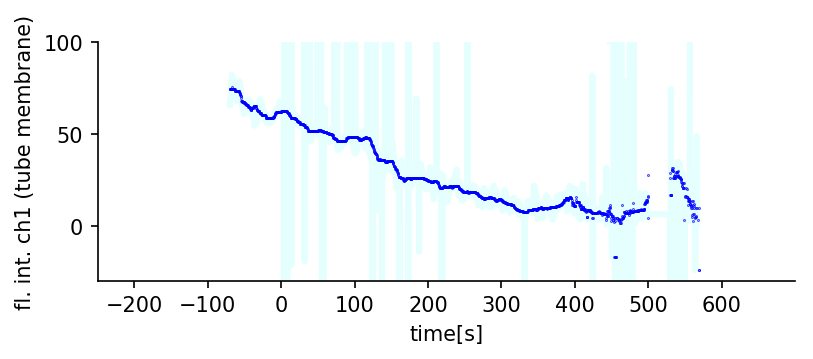

In [105]:
plt.figure(dpi=150)
plt.gca().set_aspect(2.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)


deltaT = int(float(inproc.getInputParameter(inputParameters,"movie_startTime_difference_UVstart_seconds")))
frameRate = float(inproc.getInputParameter(inputParameters,"time_between_frames_seconds"))
# we have a shift in time since the movie got cut out
# 
gaptimeInMovie = 1713
nMissingSecondsBeforeScndMovie = 29
time = deltaT + np.arange(0,gaptimeInMovie)*frameRate
time2 = deltaT + nMissingSecondsBeforeScndMovie+ np.arange(gaptimeInMovie,len(frames))*frameRate
time = np.concatenate([time,time2])


print(time)

df_fit_ch0 = pd.read_csv(filenamePath_gaussFit_ch0)
plt.plot(time,df_fit_ch0['maxx-background_median'],color='cyan',lw=3,alpha=0.1)
plt.plot(time,scipy.ndimage.median_filter(df_fit_ch0['maxx-background_median'],60),lw=0,c='blue',marker='o',markersize=0.3);
plt.xlabel('time[s]')
plt.ylabel('fl. int. ch1 (tube membrane)')
plt.ylim(-30,100)
plt.xlim(-250,700)
plt.xticks(np.arange(-200, 700, 100.0))



filenamePath_gaussFit_ch0_pretty = path+outputDataFolder+movie_zoomVesicle_ch0+'__gaussFitAlongTube_medianFilter60.csv'
y = scipy.ndimage.median_filter(df_fit_ch0['maxx-background_median'],60)
d = {'time[s]': time.tolist(), 'fluorescenceIntensityTube[AU]': y.tolist()}
df = pd.DataFrame(data=d)
df.to_csv(filenamePath_gaussFit_ch0_pretty)

# channel 1

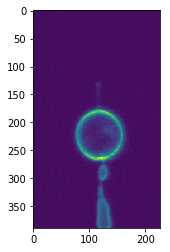

In [63]:
inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")
movie_zoomVesicle_ch1 = "movie_ch1_avg20_bleachCorrected.tif"

frames_ch1 = pims.TiffStack_pil(path+inputDataFolder+movie_zoomVesicle_ch1) 
plt.imshow(frames[0])

[ 153.  114.]


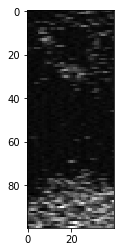

In [64]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch1

frameId = 0
image = frames[frameId]
marginx = 50 #display margin in x around tube midpoint
marginy = 20 #display margin in y around tube midpoint
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)
midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()

[ 153.  114.]
37.0135110466
14 14


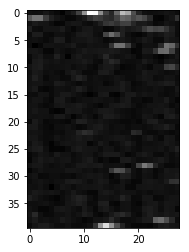

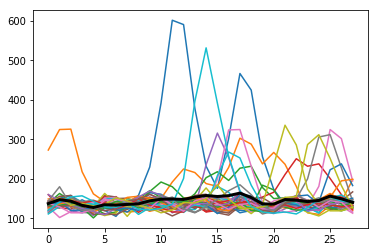

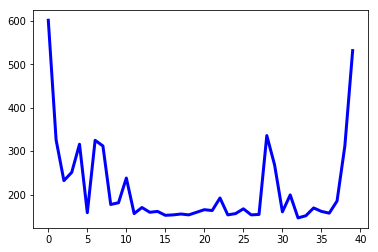

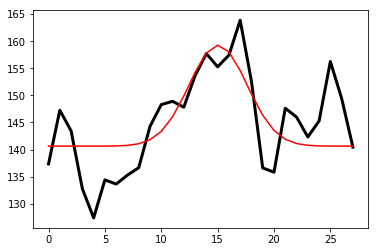

mean: 15.0411528799 stdev: 2.57101923054 max: 159.276049658 FWHM: 6.05475028792 offset: 140.629718367 maxx: 159.276049658
fit parameters: mean: 15.04115287993951 variance: 2.5710192305403305 amplitude: 120.16795081404527 yshift: 140.62971836694993


In [65]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points



frames = frames_ch1

frameId = 0
image = frames[frameId]
marginx = 20
marginy = -1 # will be calculated from tube length

#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)

tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
print(tubeLength)
marginy = int(0.8*tubeLength/2)
print(marginy,marginy)

midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()


#----------------
# look at the individual lines

for line in image_centeredOnVesicleAttachmentVector:
    plt.plot(line)

plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
plt.show()

maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
plt.plot(maximaForEveryLine,color='b',lw=3)    
plt.show()


#----------------
# average the individual lines

averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
# guess that the center sits on the max                               
guess_mean = np.argmax(averagedIntensity)
# guess that the variance is where the halfmax is
halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
# get the indexes of the elements to the right of the maximum that are larger than the halfmax
indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
# the length of that list is our sigma guess
guess_sigma = len(indexes)

# our guess for the y-shift is the minimum of the averaged traces
guess_yShift = np.min(averagedIntensity)

# out guess for the amplitude is the difference between min and max of the trace
guess_amplitude = halfmax*2


                               
                               
                               
#----------------  
# do the fit:
                               
p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
#print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=True);


amplitude = fit[5] #maxx-offset





In [66]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch1

outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")

verbose = False
fits = []

counter = 0
#for frameId in range(0,10):
for frameId in range(0,len(frames)):
    
    if(counter%10==0):
        print(counter)
    try:
        image = frames[frameId]
        marginx = 20
        marginy = -1 # will be calculated from tube length
        
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                          df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
        beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                          df_tubeVector['bead_attachment_y'].iloc[frameId]]
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
        #print(tubeMidpoint)
        
        tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
        #print(tubeLength)
        marginy = int(0.8*tubeLength/2)
        #print(marginy,marginy)
        
        midx = int(tubeMidpoint[0])
        midy = int(tubeMidpoint[1])
        image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]
    
        if(verbose):
            plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')
            plt.show()
            
            
        try:    
            maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
            filename_maxEveryLine = path+outputDataFolder+movie_zoomVesicle_ch1+'__flIntMaxAlongTube_'+str(counter)+'.csv'
            df = pd.DataFrame(maximaForEveryLine)
            df.to_csv(filename_maxEveryLine, header=['fluorescenceMaximaForEveryLineAlongTubeVector'])
        except ValueError:
            print('something went wrong. skip')
        
        if(verbose):
            plt.plot(maximaForEveryLine,color='b',lw=3)    
            plt.show()
        
        
        if(verbose):
            for line in image_centeredOnVesicleAttachmentVector:
                plt.plot(line)
            plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
            plt.show()
        
        averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
        # guess that the center sits on the max                               
        guess_mean = np.argmax(averagedIntensity)
        # guess that the variance is where the halfmax is
        halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
        # get the indexes of the elements to the right of the maximum that are larger than the halfmax
        indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
        # the length of that list is our sigma guess
        guess_sigma = len(indexes)
        
        # our guess for the y-shift is the minimum of the averaged traces
        guess_yShift = np.min(averagedIntensity)
        
        # out guess for the amplitude is the difference between min and max of the trace
        guess_amplitude = halfmax*2
        
        
                                       
                                       
                                       
                
        
                                       
        p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
        if(False):
            print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
       
        fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=verbose);
    except (TypeError, ZeroDivisionError,IndexError) as e:
        fit = np.array([])
    fits.append(fit)
    counter = counter +1
    
    

fits = np.array(fits)
filenamePath_gaussFit_ch1 = path+outputDataFolder+movie_zoomVesicle_ch1+'__gaussFitAlongTube.csv'
df = pd.DataFrame(fits.tolist())
df.to_csv(filenamePath_gaussFit_ch1,header=['mean','stdev','fit[0][2]','offset','maxx','maxx-offset','FWHM','fitconvergence','background_median','maxx-background_median'])

0


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300


/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in multiply
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2))

1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


1800
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1810
1820
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1830
something went wrong. skip
something went wrong. skip


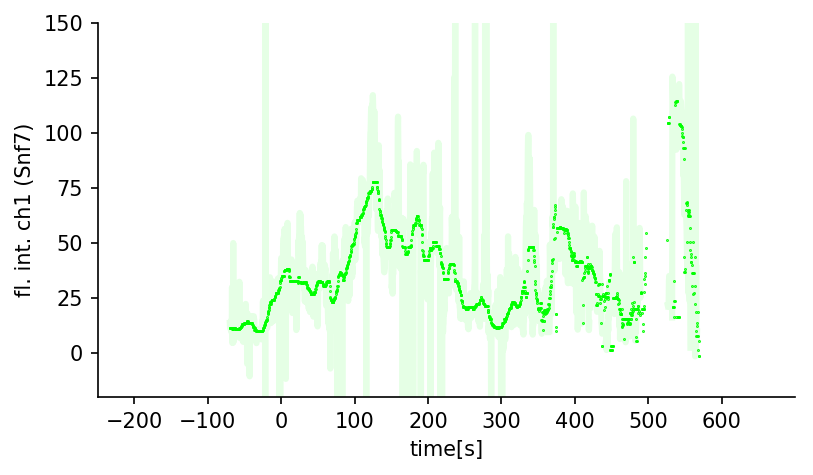

In [103]:
plt.figure(dpi=150)
plt.gca().set_aspect(3)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

deltaT = int(float(inproc.getInputParameter(inputParameters,"movie_startTime_difference_UVstart_seconds")))
frameRate = float(inproc.getInputParameter(inputParameters,"time_between_frames_seconds"))

gaptimeInMovie = 1703
nMissingSecondsBeforeScndMovie = 29
time = deltaT + np.arange(0,gaptimeInMovie)*frameRate
time2 = deltaT + nMissingSecondsBeforeScndMovie+ np.arange(gaptimeInMovie,len(frames))*frameRate
time = np.concatenate([time,time2])

df_fit_ch1 = pd.read_csv(filenamePath_gaussFit_ch1)
plt.plot(time,df_fit_ch1['maxx-background_median'],color='lime',lw=3,alpha=0.1)
plt.plot(time,scipy.ndimage.median_filter(df_fit_ch1['maxx-background_median'],60),lw=0,c='lime',marker='o',markersize=0.4);
plt.xlabel('time[s]')
plt.ylabel('fl. int. ch1 (Snf7)')
plt.ylim(-20,150)
plt.xlim(-250,700)
plt.xticks(np.arange(-200, 700, 100.0))


filenamePath_gaussFit_ch1_pretty = path+outputDataFolder+movie_zoomVesicle_ch1+'__gaussFitAlongTube_medianFilter60.csv'
y = scipy.ndimage.median_filter(df_fit_ch1['maxx-background_median'],60)
d = {'time[s]': time.tolist(), 'fluorescenceIntensityTube[AU]': y.tolist()}
df = pd.DataFrame(data=d)
df.to_csv(filenamePath_gaussFit_ch1_pretty)

# ch2 analysis 

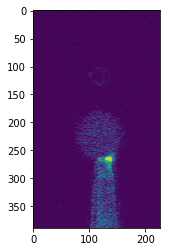

In [86]:
inputDataFolder = inproc.getInputParameter(inputParameters,"input_data_folder")
movie_zoomVesicle_ch2 = "movie_ch2_avg20_bleachCorrected.tif"

frames_ch2 = pims.TiffStack_pil(path+inputDataFolder+movie_zoomVesicle_ch2) 
plt.imshow(frames[0])

[ 153.  114.]


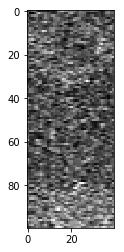

In [87]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch2

frameId = 0
image = frames[frameId]
marginx = 50 #display margin in x around tube midpoint
marginy = 20 #display margin in y around tube midpoint
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)
midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()

[ 153.  115.]
37.0540146273
14 14


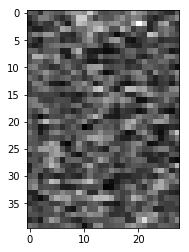

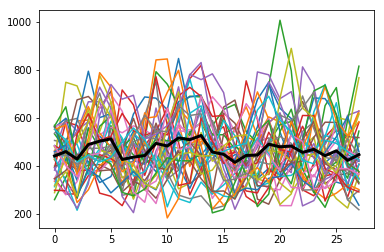

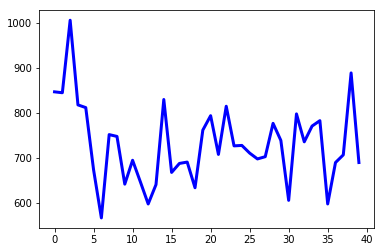

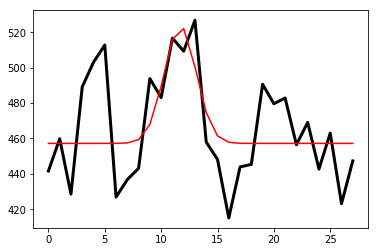

mean: 11.6912714431 stdev: 1.41108761698 max: 523.661708959 FWHM: 3.32311133799 offset: 457.219218557 maxx: 523.661708959
fit parameters: mean: 11.691271443064762 variance: 1.411087616982151 amplitude: 235.01188029997726 yshift: 457.2192185567355
amplitude above background: 1.0[AU]


In [88]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points



frames = frames_ch2

frameId = 3
image = frames[frameId]
marginx = 20
marginy = -1 # will be calculated from tube length

#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                  df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                  df_tubeVector['bead_attachment_y'].iloc[frameId]]
#image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
print(tubeMidpoint)

tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
print(tubeLength)
marginy = int(0.8*tubeLength/2)
print(marginy,marginy)

midx = int(tubeMidpoint[0])
midy = int(tubeMidpoint[1])
image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]

plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')

plt.show()


#----------------
# look at the individual lines

for line in image_centeredOnVesicleAttachmentVector:
    plt.plot(line)

plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
plt.show()

maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
plt.plot(maximaForEveryLine,color='b',lw=3)    
plt.show()


#----------------
# average the individual lines

averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
# guess that the center sits on the max                               
guess_mean = np.argmax(averagedIntensity)
# guess that the variance is where the halfmax is
halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
# get the indexes of the elements to the right of the maximum that are larger than the halfmax
indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
# the length of that list is our sigma guess
guess_sigma = len(indexes)

# our guess for the y-shift is the minimum of the averaged traces
guess_yShift = np.min(averagedIntensity)

# out guess for the amplitude is the difference between min and max of the trace
guess_amplitude = halfmax*2


                               
                               
                               
#----------------  
# do the fit:
                               
p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
#print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=True);


amplitude = fit[7] #maxx-background
print("amplitude above background: {}[AU]".format(amplitude))






In [89]:
# crop image around vesicle attachment point
# this is necessary because otherwise i will rotate the image and it will rotate it away from my learned attachment points
frames = frames_ch2

outputDataFolder = inproc.getInputParameter(inputParameters,"output_data_folder")

verbose = False
fits = []

counter = 0
#for frameId in range(0,10):
for frameId in range(0,len(frames)):
    
    if(counter%10==0):
        print(counter)
    try:
        image = frames[frameId]
        marginx = 20
        marginy = -1 # will be calculated from tube length
        
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        vesiclePoint = [df_tubeVector['vesicle_attachment_x'].iloc[frameId],
                          df_tubeVector['vesicle_attachment_y'].iloc[frameId]]
        beadPoint = [df_tubeVector['bead_attachment_x'].iloc[frameId],
                          df_tubeVector['bead_attachment_y'].iloc[frameId]]
        #image_centeredOnVesicleAttachmentVector = (image[20:50,10:50])
        tubeMidpoint = tubeProc.get_tube_midpoint(vesiclePoint,beadPoint)
        #print(tubeMidpoint)
        
        tubeLength = tubeProc.get_tube_length(vesiclePoint,beadPoint)
        #print(tubeLength)
        marginy = int(0.8*tubeLength/2)
        #print(marginy,marginy)
        
        midx = int(tubeMidpoint[0])
        midy = int(tubeMidpoint[1])
        image_centeredOnVesicleAttachmentVector = image[midx-marginx:midx+marginx,midy-marginy:midy+marginy]
    
        if(verbose):
            plt.imshow(image_centeredOnVesicleAttachmentVector,cmap='gray')
            plt.show()
            
        try:    
            maximaForEveryLine = np.max(image_centeredOnVesicleAttachmentVector,axis=1)
            filename_maxEveryLine = path+outputDataFolder+movie_zoomVesicle_ch2+'__flIntMaxAlongTube_'+str(counter)+'.csv'
            df = pd.DataFrame(maximaForEveryLine)
            df.to_csv(filename_maxEveryLine, header=['fluorescenceMaximaForEveryLineAlongTubeVector'])
        except ValueError:
            print('something went wrong. skip')
        
        if(verbose):
            plt.plot(maximaForEveryLine,color='b',lw=3)    
            plt.show()
        
        
        if(verbose):
            for line in image_centeredOnVesicleAttachmentVector:
                plt.plot(line)
            plt.plot(np.average(image_centeredOnVesicleAttachmentVector,axis=0),color='k',lw=3)    
            plt.show()
        
        averagedIntensity = np.average(image_centeredOnVesicleAttachmentVector,axis=0)
        # guess that the center sits on the max                               
        guess_mean = np.argmax(averagedIntensity)
        # guess that the variance is where the halfmax is
        halfmax = np.max(averagedIntensity)-np.min(averagedIntensity)/2
        # get the indexes of the elements to the right of the maximum that are larger than the halfmax
        indexes = [i for i,v in enumerate(averagedIntensity[guess_mean:-1]) if v > halfmax]
        # the length of that list is our sigma guess
        guess_sigma = len(indexes)
        
        # our guess for the y-shift is the minimum of the averaged traces
        guess_yShift = np.min(averagedIntensity)
        
        # out guess for the amplitude is the difference between min and max of the trace
        guess_amplitude = halfmax*2
        
        
                                       
                                       
                                       
                
        
                                       
        p0_guess = [guess_mean,guess_sigma,guess_amplitude,guess_yShift];
        if(False):
            print("p0_guess: mean: {} variance: {} amplitude: {} yshift: {}".format(guess_mean,guess_sigma,guess_amplitude,guess_yShift))
       
        fit = tubeProc.fitGaussian(averagedIntensity,p0=p0_guess,verbose=verbose);
    except (TypeError, ZeroDivisionError,IndexError) as e:
        fit = np.array([])
    fits.append(fit)
    counter = counter +1
    
    

fits = np.array(fits)
filenamePath_gaussFit_ch2 = path+outputDataFolder+movie_zoomVesicle_ch2+'__gaussFitAlongTube.csv'
df = pd.DataFrame(fits.tolist())
df.to_csv(filenamePath_gaussFit_ch2,header=['mean','stdev','fit[0][2]','offset','maxx','maxx-offset','FWHM','fitconvergence','background_median','maxx-background_median'])

0


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


10
20
30
40
50
60
70
80
90
100
110
120


/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: divide by zero encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in true_divide
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2)))
/Users/johannesschoeneberg/git/JohSchoeneberg/Confleezers/confleezers_data_analysis//modules/TubeProcessing.py:23: RuntimeWarning: invalid value encountered in multiply
  return B[3]+B[2]/(B[1]*np.sqrt(2*np.pi))*np.exp(-((x-B[0])**2/(2*B[1]**2))

130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790


/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/johannesschoeneberg/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4016: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


1800
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1810
1820
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
something went wrong. skip
1830
something went wrong. skip
something went wrong. skip


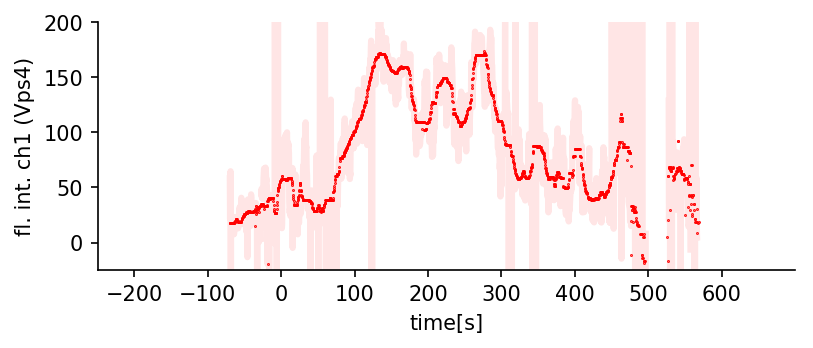

In [101]:
plt.figure(dpi=150)
plt.gca().set_aspect(1.5)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

deltaT = int(float(inproc.getInputParameter(inputParameters,"movie_startTime_difference_UVstart_seconds")))
frameRate = float(inproc.getInputParameter(inputParameters,"time_between_frames_seconds"))
gaptimeInMovie = 1703
nMissingSecondsBeforeScndMovie = 29
time = deltaT + np.arange(0,gaptimeInMovie)*frameRate
time2 = deltaT + nMissingSecondsBeforeScndMovie+ np.arange(gaptimeInMovie,len(frames))*frameRate
time = np.concatenate([time,time2])

df_fit_ch2 = pd.read_csv(filenamePath_gaussFit_ch2)
plt.plot(time,df_fit_ch2['maxx-background_median'],color='red',alpha=0.1,lw=3)
plt.plot(time,scipy.ndimage.median_filter(df_fit_ch2['maxx-background_median'],60),lw=0,c='red',marker='o',markersize=0.4);
plt.xlabel('time[s]')
plt.ylabel('fl. int. ch1 (Vps4)')
plt.ylim(-25,200)
plt.xlim(-250,700)
plt.xticks(np.arange(-200, 700, 100.0))

filenamePath_gaussFit_ch2_pretty = path+outputDataFolder+movie_zoomVesicle_ch2+'__gaussFitAlongTube_medianFilter60.csv'
y = scipy.ndimage.median_filter(df_fit_ch2['maxx-background_median'],60)
d = {'time[s]': time.tolist(), 'fluorescenceIntensityTube[AU]': y.tolist()}
df = pd.DataFrame(data=d)
df.to_csv(filenamePath_gaussFit_ch2_pretty)